In [1]:
using PyPlot
using Cubature 


include("DG_Functions.jl")
include("Specific_DG_Functions.jl")
include("DG_Methods.jl")

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


reconstruct_DG (generic function with 1 method)

In [4]:
hier_coefficients_DG(3,(x-> sin(pi*x[1]+x[2])),(3,3));
Profile.clear();
@profile hier_coefficients_DG(3,(x-> sin(pi*x[1]+x[2])),(3,3));
Profile.print();
@time hier_coefficients_DG(3,(x-> sin(pi*x[1]+x[2])),(3,3));

1   ...lia Code/DG_Methods.jl; anonymous; line: 40
1   ...ecific_DG_Functions.jl; h; line: 50
599 task.jl; anonymous; line: 447
 599 .../IJulia/src/IJulia.jl; eventloop; line: 143
  599 ...rc/execute_request.jl; execute_request_0x535c5df2; line: 183
   599 loading.jl; include_string; line: 282
    599 profile.jl; anonymous; line: 16
     599 ...a Code/DG_Methods.jl; hier_coefficients_DG; line: 123
      598 ... Code/DG_Methods.jl; get_coefficient_DG; line: 103
       3   ... Code/DG_Methods.jl; inner_product; line: 92
        3 .../lib/julia/sys.dylib; ntuple; (unknown line)
         1 ... Code/DG_Methods.jl; anonymous; line: 92
       595 ... Code/DG_Methods.jl; inner_product; line: 95
        595 ...ure/src/Cubature.jl; hcubature; line: 227
         595 ...re/src/Cubature.jl; cubature; line: 196
          1   ...re/src/Cubature.jl; sintegrand; line: 85
          8   ...re/src/Cubature.jl; sintegrand; line: 86
          2   ...re/src/Cubature.jl; sintegrand; line: 87
          531 ...

In [6]:
sparse_coefficients_DG(3,(x-> sin(pi*x[1]+x[2])),4,2);
Profile.clear();
@profile sparse_coefficients_DG(3,(x-> sin(pi*x[1]+x[2])),4,2);
Profile.print();
@time scoeffs=sparse_coefficients_DG(3,(x-> sin(pi*x[1]+x[2])),4,2);

2    In[6]; anonymous; line: 3
1    array.jl; getindex; line: 283
1255 task.jl; anonymous; line: 447
 1255 .../IJulia/src/IJulia.jl; eventloop; line: 143
  1255 ...rc/execute_request.jl; execute_request_0x535c5df2; line: 183
   1255 loading.jl; include_string; line: 282
    1255 profile.jl; anonymous; line: 16
     2    ... Code/DG_Methods.jl; sparse_coefficients_DG; line: 152
     1    ... Code/DG_Methods.jl; sparse_coefficients_DG; line: 155
      1 abstractarray.jl; setindex!; line: 592
     1252 ... Code/DG_Methods.jl; sparse_coefficients_DG; line: 157
      1251 ... Code/DG_Methods.jl; get_coefficient_DG; line: 103
       5    ... Code/DG_Methods.jl; inner_product; line: 92
        4 .../lib/julia/sys.dylib; ntuple; (unknown line)
         2 ... Code/DG_Methods.jl; anonymous; line: 92
       1    ... Code/DG_Methods.jl; inner_product; line: 93
        1 .../lib/julia/sys.dylib; ntuple; (unknown line)
       1245 ... Code/DG_Methods.jl; inner_product; line: 95
        1245 ...re/sr

In [6]:
@time get_coefficient_DG(3,x->sin(pi*x[1]+x[2]),(2,2),CartesianIndex{2}((1,1)),CartesianIndex{2}((2,2)))
Profile.clear(); @profile get_coefficient_DG(3,x->sin(pi*x[1]+x[2]),(2,2),CartesianIndex{2}((1,1)),CartesianIndex{2}((2,2))); Profile.print()

  0.016124 seconds (439.00 k allocations: 7.349 MB)
22 task.jl; anonymous; line: 447
 22 ...4/IJulia/src/IJulia.jl; eventloop; line: 143
  22 ...rc/execute_request.jl; execute_request_0x535c5df2; line: 183
   22 loading.jl; include_string; line: 282
    22 profile.jl; anonymous; line: 16
     22 In[4]; inner_product; line: 92
      22 ...ture/src/Cubature.jl; hcubature; line: 227
       22 ...ure/src/Cubature.jl; cubature; line: 196
        20 ...ure/src/Cubature.jl; sintegrand; line: 88
         17 In[4]; anonymous; line: 91
          14 In[4]; anonymous; line: 37
           14 In[4]; V; line: 28
            7 In[4]; v; line: 13
             7 ...ic_DG_Functions.jl; h; line: 51
              1 ...c_DG_Functions.jl; array2poly; line: 12
              6 ...c_DG_Functions.jl; array2poly; line: 17
               1 ...e/DG_Functions.jl; f; line: 7
               2 ...e/DG_Functions.jl; f; line: 11
          2  In[6]; anonymous; line: 2
        1  ...ure/src/Cubature.jl; sintegrand; line: 8

In [8]:
scoeffs[CartesianIndex{2}((2,1))]

1x1 Array{Array{Float64,N},2}:
 3x3 Array{Float64,2}:
 -0.0263799  -0.0141776    0.00100713 
 -0.0126997   0.00203699   0.000484847
  0.0285957   0.0153684   -0.00109172 

In [6]:
[inner_product(V(3, (0,0),CartesianIndex{2}((1,1)),CartesianIndex{2}((i,j))),(x->sin(pi*x[1]+x[2])),(0,0),CartesianIndex{2}((1,1))) 
    for i in 1:3, j in 1:3]

3x3 Array{Float64,2}:
  0.535697  -0.085924   -0.0204518 
 -0.322696  -0.173429    0.0123198 
 -0.258562   0.0414725   0.00987135

In [198]:
@time V(3, (2,1),CartesianIndex{2}((2,1)),CartesianIndex{2}((2,1)))([.6,.3])

@time v(3, 2, 2, 2, .6)

@time sin(0.313244)

@time hcubature(x->sin(pi*x[1]+x[2]), [0,0], [1,1]; reltol=1e-8, abstol=1e-5, maxevals=0)

@time get_coefficient_DG(3,x->sin(pi*x[1]+x[2]),(1,2),CartesianIndex{2}((1,1)),CartesianIndex{2}((2,2)))

  0.000039 seconds (47 allocations: 1.375 KB)
  0.000011 seconds (19 allocations: 560 bytes)
  0.000002 seconds (5 allocations: 176 bytes)
  0.001583 seconds (1.00 k allocations: 23.670 KB)
  0.021442 seconds (82.96 k allocations: 1.978 MB, 75.29% gc time)


1.0894052669282951e-7

In [219]:
@time [inner_product(V(3, (2,0),CartesianIndex{2}((2,1)),CartesianIndex{2}((i,j))), x->sin(pi*x[1]+x[2]),(0,0),CartesianIndex{2}((1,1)))
    for i in 1:3, j in 1:3]

  0.014339 seconds (316.98 k allocations: 7.156 MB)


3x3 Array{Float64,2}:
 -0.00510084   -0.000439415   0.000194745
 -0.000194615   0.000194746   7.42671e-6 
  0.00566066    0.000487642  -0.000216114

In [72]:
[get_coefficient_DG(3,x->sin(pi*x[1]+x[2]),(2,0),CartesianIndex{2}((2,1)),CartesianIndex{2}((i,j)))
    for i in 1:3, j in 1:3]

[inner_product(x->sin(pi*x[1]+x[2]), V(3,(2,0),CartesianIndex{2}((2,1)),CartesianIndex{2}((i,j))),(1,1),CartesianIndex{2}((1,1)))
    for i in 1:3, j in 1:3]

3x3 Array{Float64,2}:
 -0.00510084   -0.000439415   0.000194739
 -0.000194614   0.000194744   7.42996e-6 
  0.00566066    0.000487642  -0.000216112

In [95]:
coeffs[CartesianIndex{2}((3,1))]

2x1 Array{Array{Float64,N},2}:
 3x3 Array{Float64,2}:
  0.00149663   -0.00149763  -5.71381e-5
 -0.000663289  -5.71395e-5   2.5323e-5 
 -0.00166088    0.00166199   6.3409e-5       
 3x3 Array{Float64,2}:
 -0.00510084   -0.000439415   0.000194739
 -0.000194614   0.000194744   7.42996e-6 
  0.00566066    0.000487642  -0.000216112

In [14]:
Profile.clear()
@time reconstruct_DG(3, scoeffs, [.3,.5])
Profile.print()

  0.000305 seconds (1.43 k allocations: 37.844 KB)


running it multiple times), or adjust the delay between samples with
Profile.init().


In [5]:
Profile.clear()
@profile plotfunc2D(x->reconstruct_DG(3, scoeffs, [x[1],x[2]])-sin(pi*x[1]+x[2]))
Profile.print()

LoadError: LoadError: UndefVarError: scoeffs not defined
while loading In[5], in expression starting on line 2

In [106]:
coeffs

Dict{CartesianIndex{2},Array{Array{Float64,N},2}} with 9 entries:
  CartesianIndex{2}((3,3)) => 2x2 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((1,3)) => 1x2 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((3,1)) => 2x1 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((3,2)) => 2x1 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((1,2)) => 1x1 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((1,1)) => 1x1 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((2,1)) => 1x1 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((2,3)) => 1x2 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((2,2)) => 1x1 Array{Array{Float64,N},2}:…

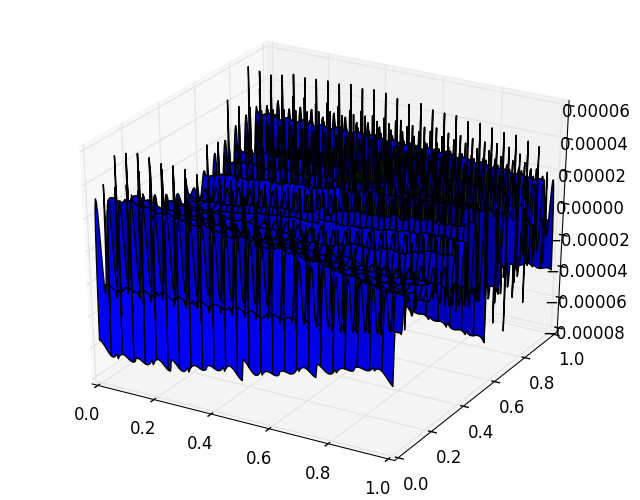

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x31eda63d0>

In [7]:
plotfunc2D(x->reconstruct_DG(3, scoeffs, [x[1],x[2]])-sin(pi*x[1]+x[2]))

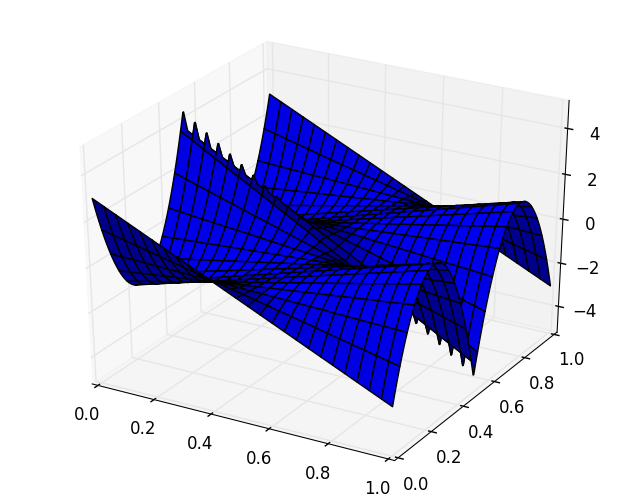

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x31e3123d0>

In [3]:
#get_coefficient_DG(3,(x-> sin(pi*x[1]+x[2])),(1,0),CartesianIndex{2}((1,1)),CartesianIndex{2}((2,1)))
#inner_product((x-> sin(pi*x[1]+x[2])), V(k,lvl,place,f_number),lvl,place)
#plotfunc2D(V(3,(1,0),CartesianIndex{2}((1,1)),CartesianIndex{2}((2,1))))
plotfunc2D(x->V(3,(1,0),CartesianIndex{2}((1,1)),CartesianIndex{2}((2,1)),[x[1],x[2]]))

In [180]:
function ArrayTest(A::AbstractArray{Int})
    return A[1]
end

ArrayTest (generic function with 1 method)

In [183]:
a=[3,2,1]
a=CartesianIndex{3}((1,2,1))
a=(1,3,2)
ArrayTest(a)

LoadError: LoadError: MethodError: `ArrayTest` has no method matching ArrayTest(::Tuple{Int64,Int64,Int64})
while loading In[183], in expression starting on line 4